In [2]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

In [26]:
#Read in surface stats
db = pickle.load(open('workspace/SFstats.pck','rb'))
#Read in LES output
file = 'workspace/LESoutput.pck'
les_db = pickle.load(open(file,'rb'))

In [27]:
#Assemble metrics
metrics = {}
for var in ['TKE','LWP']:
 metrics[var] = []
 #Perform analysis at each date
 for date in les_db:
     if (np.sum(les_db[date]['HMG'][var] != -9999) >= 90) & (np.sum(les_db[date]['HTG'][var] != -9999) >= 90):
         metrics[var].append(np.mean(les_db[date]['HTG'][var]-les_db[date]['HMG'][var]))
     else:
         metrics[var].append(-9999)
 metrics[var] = np.array(metrics[var])
 m = metric != -9999

0.5153326322142393


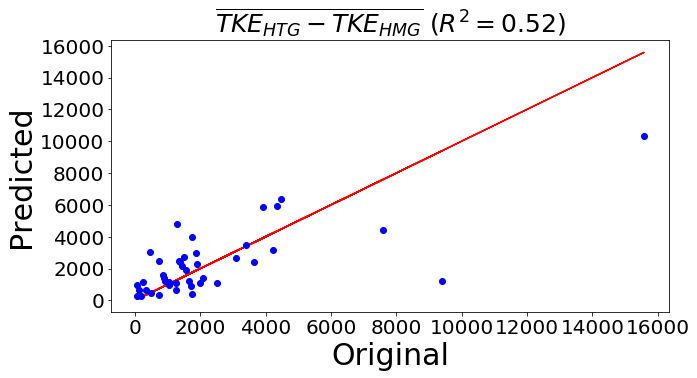

In [43]:
from sklearn.linear_model import LinearRegression
import sklearn.metrics
var = 'TKE'
metric = metrics[var]
m2 = m #& (metric < 7000)
#X = np.array([db['SH_L0_0.75'][m2],db['SH_L90'][m2],db['SH_var'][m2],db['SH_skew'][m2],db['SH_kurt'][m2]]).T
#X = np.array([db['SH_L0_0.50'][m2],db['SH_L90_0.50'][m2],db['SH_var'][m2],db['SH_skew'][m2],db['SH_kurt'][m2]]).T
X = np.array([db['SH_L0_0.75'][m2],db['SH_L90_0.75'][m2]]).T
#X = np.array([db['SH_L0_0.75'][m2],db['SH_L0_0.50'][m2],db['SH_L0_0.25'][m2],db['SH_L90_0.75'][m2],db['SH_L90_0.50'][m2],db['SH_L90_0.25'][m2]]).T
y = metric[m2]
#regr = RandomForestRegressor(random_state=0,n_estimators=250,oob_score=True).fit(X,y)
regr = LinearRegression().fit(X, y)
ypred = regr.predict(X)
print(sklearn.metrics.explained_variance_score(y,ypred))
plt.figure(figsize=(10,5))
plt.plot(y,y,'r')
plt.plot(y,ypred,'bo')
plt.xlabel('Original',fontsize=30)
plt.ylabel('Predicted',fontsize=30)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.title(r'$\overline{TKE_{HTG} - TKE_{HMG}}$ ($R^2 = %.2f$)' % sklearn.metrics.explained_variance_score(y,ypred),fontsize=25)
#plt.title(r'$\overline{LWP_{HTG} - LWP_{HMG}}$ ($R^2 = %.2f$)' % metrics.explained_variance_score(y,ypred),fontsize=25)
plt.show()

In [ ]:
#Read in the list of dates
file = '/home/nc153/soteria/projects/CLASP/LASSO/Postprocess4LES/dates_org.txt'
dates = []
for line in open(file):
    date = datetime.datetime.strptime(line[:-1], "%m-%d-%Y")
    dates.append(date)
dates = np.array(dates)

In [ ]:
#Collect dates of simulations for both HMG and HTG
hmg_dates = []
htg_dates = []
#HMG
files = glob.glob('/stor/soteria/hydro/shared/lasso_for_nate/doz_ultlites_01/*')
for file in files:
    tmp = datetime.datetime.strptime(file.split('/')[-1][12:-3],'%Y-%m-%d_%H:%M')
    hmg_dates.append(tmp)
hmg_dates = np.sort(np.array(hmg_dates))
#HTG
files = glob.glob('/stor/soteria/hydro/shared/lasso_for_nate/doz_ultlites_00/*')
for file in files:
    tmp = datetime.datetime.strptime(file.split('/')[-1][12:-3],'%Y-%m-%d_%H:%M')
    htg_dates.append(tmp)
htg_dates = np.sort(np.array(htg_dates))

In [ ]:
#Read in the HMG/HTG TKE + LWP for ones that are finished
odb = {}
count = 0
for date in dates:#[datetime.datetime(2016,8,19),]:#dates:
    count += 1
    print(count,date)
    tdate = date + datetime.timedelta(hours=12)
    mdates = []
    for i in range(15*6+1):
        mdates.append(tdate+i*datetime.timedelta(minutes=10))
    mdates = np.array(mdates)
    #Create list of dates
    strdate = date.strftime('%Y-%m-%d')
    odb[strdate] = {'HMG':{'LWP':np.array([]),'TKE':np.array([])},'HTG':{'LWP':np.array([]),'TKE':np.array([])}}
    #HMG
    odb[strdate]['HMG']['TKE'] = -9999*np.ones(mdates.size)
    odb[strdate]['HMG']['LWP'] = -9999*np.ones(mdates.size)
    m = (hmg_dates >= tdate) & (hmg_dates <= tdate+datetime.timedelta(hours=16))
    for tmp in hmg_dates[m]:
        file = '/stor/soteria/hydro/shared/lasso_for_nate/doz_ultlites_01/ultlite_d01_%d-%02d-%02d_%02d:%02d:00' % (tmp.year,tmp.month,tmp.day,tmp.hour,tmp.minute)
        fp = nc.Dataset(file)
        #Create list of dates inside
        tmdates = []
        for i in range(fp['CST_TKE'][:].size):
            tmdates.append(tmp + i*datetime.timedelta(minutes=10))
        tmdates = np.array(tmdates)
        CST_TKE = fp['CST_TKE'][:]
        CST_LWP = fp['CST_LWP'][:]
        for itm in range(tmdates.size):
            odb[strdate]['HMG']['TKE'][mdates == tmdates[itm]] = CST_TKE[itm] 
            odb[strdate]['HMG']['LWP'][mdates == tmdates[itm]] = CST_LWP[itm] 
    #break
    #HTG
    odb[strdate]['HTG']['TKE'] = -9999*np.ones(mdates.size)
    odb[strdate]['HTG']['LWP'] = -9999*np.ones(mdates.size)
    m = (htg_dates >= tdate) & (htg_dates <= tdate+datetime.timedelta(hours=17))
    for tmp in htg_dates[m]:
        file = '/stor/soteria/hydro/shared/lasso_for_nate/doz_ultlites_00/ultlite_d01_%d-%02d-%02d_%02d:%02d:00' % (tmp.year,tmp.month,tmp.day,tmp.hour,tmp.minute)
        #if os.path.exists(file) == False:break
        fp = nc.Dataset(file)
        #Create list of dates inside
        tmdates = []
        for i in range(fp['CST_TKE'][:].size):
            tmdates.append(tmp + i*datetime.timedelta(minutes=10))
        tmdates = np.array(tmdates)
        CST_TKE = fp['CST_TKE'][:]
        CST_LWP = fp['CST_LWP'][:]
        for itm in range(tmdates.size):
            odb[strdate]['HTG']['TKE'][mdates == tmdates[itm]] = CST_TKE[itm] 
            odb[strdate]['HTG']['LWP'][mdates == tmdates[itm]] = CST_LWP[itm]
    #Clean up 
    for var in ['TKE','LWP']:
        m = (odb[strdate]['HTG'][var] == -9999) | (odb[strdate]['HMG'][var] == -9999)
        odb[strdate]['HTG'][var][m] = -9999
        odb[strdate]['HMG'][var][m] = -9999

In [ ]:
#date = datetime.datetime(2017,6,27)
date = datetime.datetime(2016,8,19)
#date = datetime.datetime(2016,5,30)
#[datetime.datetime(2017, 6, 27, 0, 0) datetime.datetime(2016, 5, 30, 0, 0)
# datetime.datetime(2016, 8, 19, 0, 0)]
var = 'TKE'
plt.plot(odb[date.strftime('%Y-%m-%d')]['HMG'][var])
plt.plot(odb[date.strftime('%Y-%m-%d')]['HTG'][var])
plt.show()

In [ ]:
metric = []
var = 'TKE'
#Perform analysis at each date
for date in odb:
    #print(date,odb[date]['HMG'][var].size,odb[date]['HTG'][var].size)
    print(date,np.sum(odb[date]['HMG'][var]!=-9999),np.sum(odb[date]['HTG'][var]!=-9999))
    if (np.sum(odb[date]['HMG'][var] != -9999) >= 90) & (np.sum(odb[date]['HTG'][var] != -9999) >= 90):
        metric.append(np.mean(odb[date]['HTG'][var]-odb[date]['HMG'][var]))#/np.mean(odb[date]['HMG'][var]))
    else:
        metric.append(-9999)
metric = np.array(metric)
m = metric != -9999
print(np.sum(m))

In [ ]:
#Calculate the 1-2 km mean wind speed and direction
#db = {'ws':[],'theta':[]}
db['ws'] = []
db['theta'] = []
db['q'] = []
for date in dates:#[datetime.datetime(2017,6,27),dates[1]]:#dates:
    print(date)
    file = '/stor/soteria/hydro/shared/lasso_for_nate/lasso_download/sgp%d%02d%02d/config/input_sounding' % (date.year,date.month,date.day)
    data = np.loadtxt(file,skiprows=1)
    z = data[:,0]
    dz = z[1:]-z[:-1]
    iz = (z[1:] >= 2000) & (z[1:] <= 20000)#20000)
    zav = (z[1:] + z[1:])/2
    f = dz[iz]/np.sum(dz[iz])
    u = ((data[1:,-2] + data[0:-1,-2])/2)[iz]
    v = ((data[1:,-1] + data[0:-1,-1])/2)[iz]
    #q = ((data[1:,-3] + data[0:-1,-3])/2)[iz]
    #q_va = np.sum(q[zav < 2000])
    ug = np.sum(f*u)
    vg = np.abs(np.sum(f*v))
    #Calculate magnitude
    db['ws'].append((ug**2 + vg**2)**0.5)
    db['theta'].append(np.arctan2(vg,ug)) #only 0-180 degrees (on purpose)
    db['q'].append(q_va)
    print(np.arctan2(vg,ug),np.degrees(np.arctan2(vg,ug)))
for var in db:
    db[var] = np.array(db[var])

In [ ]:
#Calculate atmospheric metrics from VARANAL
vdates = []
date = datetime.datetime(2015,1,1,0,0)
while date <= datetime.datetime(2018,10,31,23):
    vdates.append(date)
    date = date + datetime.timedelta(hours=1)
vdates = np.array(vdates)
file = '/stor/soteria/hydro/shared/varanal/sgp60varanarap.nc'
fp = nc.Dataset(file)
P = fp['lev'][:]
T = fp['T'][:]
fp.close()

In [ ]:
import metpy.calc,metpy.units
static_stability = []
for date in dates:
    ss = []
    for hour in range(15,22):
        mss = vdates == datetime.datetime(date.year,date.month,date.day,hour)
        Tsite = T[mss,:][0,:]
        Psite = 100*P[:]
        print(Tsite)
        print(Psite)
        Tsite = metpy.units.units.Quantity(Tsite,"K")
        Psite = metpy.units.units.Quantity(Psite,"Pa")
        ss.append(np.mean(metpy.calc.static_stability(Psite,Tsite)).magnitude)
        print(metpy.calc.static_stability(Psite,Tsite))
        break
    static_stability.append(np.mean(ss))
    break
static_stability = np.array(static_stability)

In [ ]:
nx = 10
iinew = -7
print(iinew % nx)

In [ ]:
import time

@jit(nopython=True)
def calculate_ns(data,h,dx,mu,step):
    Q = 0.0
    count = 0
    inew = int(h/dx)
    for i in range(0,data.shape[0],step):
        for j in range(0,data.shape[1],step):
            iinew = i + inew
            if iinew >= data.shape[0]:iinew = iinew % data.shape[0]
            Q += (data[i,j]-mu)*(data[iinew,j]-mu)
            count += 1
            iinew = i - inew
            if iinew < 0:iinew = iinew % data.shape[0]
            Q += (data[i,j]-mu)*(data[iinew,j]-mu)
            count += 1
            #if (i+inew) < data.shape[0]:
            #    Q += (data[i,j]-mu)*(data[i+inew,j]-mu)
            #    count += 1
            #if (i-inew) >= 0:
            #    Q += (data[i,j]-mu)*(data[i-inew,j]-mu)
            #    count += 1
            #
    Q = Q/count

    return Q

@jit(nopython=True)
def calculate_ew(data,h,dx,mu,step):
    Q = 0.0
    count = 0
    jnew = int(h/dx)
    for i in range(0,data.shape[0],step):
        for j in range(0,data.shape[1],step):
            jjnew = j + jnew
            if jjnew >= data.shape[1]:jjnew = jjnew % data.shape[1]
            Q += (data[i,j]-mu)*(data[i,jjnew]-mu)
            count += 1
            jjnew = j - jnew
            if jjnew < 0:jjnew = jjnew % data.shape[1]
            Q += (data[i,j]-mu)*(data[i,jjnew]-mu)
            count += 1
            #if (j+jnew) < data.shape[1]:
            #    Q += (data[i,j]-mu)*(data[i,j+jnew]-mu)
            #    count += 1
            #if (j-jnew) >= 0:
            #    Q += (data[i,j]-mu)*(data[i,j-jnew]-mu)
            #    count += 1
    Q = Q/count

    return Q

@jit(nopython=True)
def calculate_swne(data,h,dx,mu,step):
    Q = 0.0
    count = 0
    jnew = int(h/dx)
    inew = int(h/dx)
    for i in range(0,data.shape[0],step):
        for j in range(0,data.shape[1],step):
            iinew = i + inew
            jjnew = j + jnew
            if iinew >= data.shape[1]:iinew = iinew % data.shape[0]
            if jjnew >= data.shape[1]:jjnew = jjnew % data.shape[1]
            Q += (data[i,j]-mu)*(data[iinew,jjnew]-mu)
            count += 1
            iinew = i - inew
            jjnew = j - jnew
            if iinew < 0:iinew = iinew % data.shape[0]
            if jjnew < 0:jjnew = jjnew % data.shape[1]
            Q += (data[i,j]-mu)*(data[iinew,jjnew]-mu)
            count += 1
            #if ((j+jnew) < data.shape[1]) & ((i+inew) < data.shape[1]):
            #    Q += (data[i,j]-mu)*(data[i+inew,j+jnew]-mu)
            #    count += 1
            #if ((j-jnew) >= 0) & ((i-inew) >= 0):
            #    Q += (data[i,j]-mu)*(data[i-inew,j-jnew]-mu)
            #    count += 1
    Q = Q/count

    return Q

@jit(nopython=True)
def calculate_nwse(data,h,dx,mu,step):
    Q = 0.0
    count = 0
    jnew = int(h/dx)
    inew = int(h/dx)
    for i in range(0,data.shape[0],step):
        for j in range(0,data.shape[1],step):
            iinew = i - inew
            jjnew = j + jnew
            if iinew < 0:iinew = iinew % data.shape[0]
            if jjnew >= data.shape[1]:jjnew = jjnew % data.shape[1]
            Q += (data[i,j]-mu)*(data[iinew,jjnew]-mu)
            count += 1
            iinew = i + inew
            jjnew = j - jnew
            if iinew >= data.shape[1]:iinew = iinew % data.shape[0]
            if jjnew < 0:jjnew = jjnew % data.shape[1]
            Q += (data[i,j]-mu)*(data[iinew,jjnew]-mu)
            count += 1
            #if ((j+jnew) < data.shape[1]) & ((i-inew) >= 0):
            #    Q += (data[i,j]-mu)*(data[i-inew,j+jnew]-mu)
            #    count += 1
            #if ((j-jnew) >= 0) & ((i+inew) < data.shape[1]):
            #    Q += (data[i,j]-mu)*(data[i+inew,j-jnew]-mu)
            #    count += 1
    Q = Q/count

    return Q
    
def calculate_anisotropic_covariance_functions(data,hs,dx=250):
    step = 1
    #calculate mean
    mu = np.mean(data)
    #N/S and E/W
    #hs = [0,250,1000,2000,3000,4000,5000,7500,10000,12500,15000,17500,20000,25000,30000,35000,40000,45000,50000]
    #hs = np.array([0,250,1000,3000,5000,10000,15000,20000,30000,40000,50000])
    Qns = np.zeros(len(hs))
    tic = time.time()
    for ih in range(len(hs)):
        Qns[ih] = calculate_ns(data,hs[ih],dx,mu,step)
    Qew = np.zeros(len(hs))
    for ih in range(len(hs)):
        Qew[ih] = calculate_ew(data,hs[ih],dx,mu,step)
    Qswne = np.zeros(len(hs))
    for ih in range(len(hs)):
        Qswne[ih] = calculate_swne(data,hs[ih],dx,mu,step)
    Qnwse = np.zeros(len(hs))
    for ih in range(len(hs)):
        Qnwse[ih] = calculate_nwse(data,hs[ih],dx,mu,step)
    #Interpolate qswne and qnwse to be on same h as ns/ew
    hsdiag = np.sqrt(2)*hs
    #interpolate
    Qswne= np.interp(hs,hsdiag,Qswne)
    Qnwse= np.interp(hs,hsdiag,Qnwse)
    print(time.time()-tic)
    return (Qns,Qew,Qswne,Qnwse)

In [ ]:
hs = np.array([0,250,1000,2000,3000,4000,5000,7500,10000,12500,15000,17500,20000,25000,30000,35000,40000,45000,50000])#,60000,70000,80000,90000,100000])
#hs = np.array([0,250,1000,3000,5000,10000,15000,20000,30000,40000,50000])
#Read in the surface field
#db['SH_Lew'] = []
#db['SH_Lns'] = []
#db['SH_Lswne'] = []
#db['SH_Lnwse'] = []
db['SH_Qew'] = []
db['SH_Qns'] = []
db['SH_Qswne'] = []
db['SH_Qnwse'] = []
db['SH_var'] = []
db['SH_mean'] = []
db['SH_data'] = []
db['SH_skew'] = []
db['SH_kurt'] = []
for date in dates:#[datetime.datetime(2016,8,19),dates[1]]:
    #dates:
    print(date)
    data = []
    for hour in range(15,22):
     file = '/stor/soteria/hydro/shared/lasso_for_nate/dx0250nx0401/jsssh_bdy_02_%d-%02d-%02d-%2d-00' % (date.year,date.month,date.day,hour)
     #file = '/stor/soteria/hydro/shared/lasso_for_nate/dx0250nx0401/jsslw_bdy_02_%d-%02d-%02d-%2d-00' % (date.year,date.month,date.day,hour)
     fp = open(file)
     data.append(np.reshape(np.loadtxt(file),(401,401)))
    data = np.array(data)
    #m = np.argmax(np.mean(np.mean(data,axis=1),axis=1))
    #print(np.array(range(10,22))[m])
    #data = data[m,:,:]
    data = np.mean(data,axis=0)
    #calculate anisotropic covariance functions
    (Qns,Qew,Qswne,Qnwse) = calculate_anisotropic_covariance_functions(data,hs,dx=250)
    #plt.plot(hs,Qns)
    #plt.plot(hs,Qew)
    #plt.plot(hs,Qswne)
    #plt.plot(hs,Qnwse)
    #plt.legend(['ns','ew','swne','nwse'])
    #plt.show()
    #plt.imshow(data,vmin=np.percentile(data,5),vmax=np.percentile(data,95),cmap='coolwarm')
    #plt.colorbar()
    #plt.show()
    #break
    #calculate correlation length (N/S)
    #ins = Qns <= 0.50*Qns[0]
    #if np.sum(ins) == 0:Lns = 50.0 #km
    #else: Lns = hs[ins][0]/1000.0 #km
    #calculate correlation length (E/W)
    #iew = Qew <= 0.50*Qew[0]
    #if np.sum(iew) == 0:Lew = 50.0 #km
    #else: Lew = hs[iew][0]/1000.0 #km
    #calculate correlation length (SW/NE)
    #iswne = Qswne <= 0.50*Qswne[0]
    #if np.sum(iswne) == 0:Lswne = np.sqrt(2)*50.0 #km
    #else: Lswne = np.sqrt(2)*hs[iswne][0]/1000.0 #km
    #calculate correlation length (NW/SE)
    #inwse = Qnwse <= 0.50*Qnwse[0]
    #if np.sum(inwse) == 0:Lnwse = np.sqrt(2)*50.0 #km
    #else: Lnwse = np.sqrt(2)*hs[inwse][0]/1000.0 #km
    #db['SH_Lew'].append(Lew)
    #db['SH_Lns'].append(Lns)
    #db['SH_Lswne'].append(Lswne)
    #db['SH_Lnwse'].append(Lnwse)
    db['SH_Qns'].append(Qns)
    db['SH_Qew'].append(Qew)
    db['SH_Qswne'].append(Qswne)
    db['SH_Qnwse'].append(Qnwse)
    db['SH_var'].append(np.var(data))
    db['SH_mean'].append(np.mean(data))
    db['SH_skew'].append(scipy.stats.skew(data.flatten()))
    db['SH_kurt'].append(scipy.stats.kurtosis(data.flatten()))
    db['SH_data'].append(data)
for var in db:
    db[var] = np.array(db[var])

In [ ]:
#Compute covariance functions parallel and perpendicular to the geostrophic wind
#Parallel
Q0 = []
for i in range(db['theta'].size):
    theta = np.degrees(db['theta'][i])
    if ((theta > 0) & (theta <= 45)):
        dt = np.radians(theta - 0)
        Q0.append(dt/(np.pi/4)*db['SH_Qswne'][i,:] + (1-dt/(np.pi/4))*db['SH_Qew'][i,:])
    elif ((theta > 45) & (theta <= 90)):
        dt = np.radians(theta - 45)
        Q0.append(dt/(np.pi/4)*db['SH_Qns'][i,:] + (1-dt/(np.pi/4))*db['SH_Qswne'][i,:])
    elif (theta > 90) & (theta <= 135):
        dt = np.radians(theta - 90)
        Q0.append(dt/(np.pi/4)*db['SH_Qnwse'][i,:] + (1-dt/(np.pi/4))*db['SH_Qns'][i,:])
    elif (theta > 135) & (theta <= 180):
        dt = np.radians(theta - 135)
        Q0.append(dt/(np.pi/4)*db['SH_Qew'][i,:] + (1-dt/(np.pi/4))*db['SH_Qnwse'][i,:])
'''        Q0.append(dt/(np.pi/4)*db['SH_Qew'][i,:] + (1-dt/(np.pi/4))*db['SH_Qswne'][i,:])
    elif ((theta > 45) & (theta <= 90)):
        dt = np.radians(theta - 45)
        print('here',dt/(np.pi/4))
        Q0.append(dt/(np.pi/4)*db['SH_Qswne'][i,:] + (1-dt/(np.pi/4))*db['SH_Qns'][i,:])
    elif (theta > 90) & (theta <= 135):
        dt = np.radians(theta - 90)
        Q0.append(dt/(np.pi/4)*db['SH_Qns'][i,:] + (1-dt/(np.pi/4))*db['SH_Qnwse'][i,:])
    elif (theta > 135) & (theta <= 180):
        dt = np.radians(theta - 135)
        Q0.append(dt/(np.pi/4)*db['SH_Qnwse'][i,:] + (1-dt/(np.pi/4))*db['SH_Qew'][i,:])'''
Q0 = np.array(Q0)
db['SH_Q0'] = np.copy(Q0)
#Perpendicular
Q90 = []
for i in range(db['theta'].size):
    theta = 90+np.degrees(db['theta'][i])
    if theta > 180:
        theta = theta - 180
    if ((theta > 0) & (theta <= 45)):
        dt = np.radians(theta - 0)
        Q90.append(dt/(np.pi/4)*db['SH_Qswne'][i] + (1-dt/(np.pi/4))*db['SH_Qew'][i])
    elif ((theta > 45) & (theta <= 90)):
        dt = np.radians(theta - 45)
        Q90.append(dt/(np.pi/4)*db['SH_Qns'][i] + (1-dt/(np.pi/4))*db['SH_Qswne'][i])
    elif (theta > 90) & (theta <= 135):
        dt = np.radians(theta - 90)
        Q90.append(dt/(np.pi/4)*db['SH_Qnwse'][i] + (1-dt/(np.pi/4))*db['SH_Qns'][i])
    elif (theta > 135) & (theta <= 180):
        dt = np.radians(theta - 135)
        Q90.append(dt/(np.pi/4)*db['SH_Qew'][i] + (1-dt/(np.pi/4))*db['SH_Qnwse'][i])
Q90 = np.array(Q90)
db['SH_Q90'] = np.copy(Q90)

In [ ]:
#Calculate correlation lengths
thld = 0.5
L0 = []
L90 = []
for i in range(db['SH_Q0'].shape[0]):
    hsnew = np.linspace(0,50000,2500)
    #interpolate to finer
    sh_q0_new = np.interp(hsnew,hs,db['SH_Q0'][i,:])
    #sh_q0_new[sh_q0_new < 0] = 10**-5
    #plt.plot(hsnew,np.log(sh_q0_new))
    #plt.show()
    #break
    #parallel to flow
    #ins = db['SH_Q0'][i,:] <= thld*db['SH_Q0'][i,0]
    ins = sh_q0_new <= thld*sh_q0_new[0]
    #L0.append(sh_q0_new[0]-sh_q0_new[-1])
    if np.sum(ins) == 0:L0.append(50.0) #km
    else: L0.append(hsnew[ins][0]/1000.0) #km
    #perpendicular to flow
    sh_q90_new = np.interp(hsnew,hs,db['SH_Q90'][i,:])
    #ins = db['SH_Q90'][i,:] <= thld*db['SH_Q90'][i,0]
    ins = sh_q90_new <= thld*sh_q90_new[0]
    if np.sum(ins) == 0:L90.append(50.0) #km
    else: L90.append(hsnew[ins][0]/1000.0) #km
L0 = np.array(L0)
db['SH_L0'] = np.copy(L0)
L90 = np.array(L90)
db['SH_L90'] = np.copy(L90)

In [ ]:
import pickle
db = pickle.load(open('workspace/SFstats.pck','rb'))

In [ ]:
import sklearn.model_selection
clf = LinearRegression()
#clf = RandomForestRegressor(n_estimators=250)
scores = sklearn.model_selection.cross_val_score(clf,X,y,cv=2,scoring='explained_variance')
print(np.mean(scores))
scores = sklearn.model_selection.cross_val_score(clf,X,y,cv=2,scoring='r2')
#scores = sklearn.model_selection.cross_val_score(clf,X,y,cv=2,scoring='neg_mean_squared_error')
print(np.mean(scores))

In [ ]:
var = 'SH_L90'
plt.figure(figsize=(10,5))
plt.plot(db[var][m],metric[m],'bo',markersize=10)
#print(dates[metric > 15000])?
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
print(scipy.stats.pearsonr(db[var][m],metric[m]))
print(scipy.stats.spearmanr(db[var][m],metric[m]))

In [ ]:
m2 = (metric > 7000) & (metric < 9000)
m2 = db['SH_L0'] > 40
print(dates[m2])
#plt.hist(db['SH_data'][m2,:,:][0,:,:].flatten(),bins=100)
#plt.show()
plt.imshow(db['SH_data'][m2,:,:][0,:,:],cmap='coolwarm')
plt.colorbar()
plt.show()

In [ ]:
print(dates[metric > 15000])

In [ ]:
#Calculate correlation length parallel to the geostrophic wind (choose closest direction)
L0 = []
for i in range(db['theta'].size):
    theta = np.degrees(db['theta'][i])
    if ((theta > 0) & (theta <= 45)):
        dt = np.radians(theta - 0)
        L0.append(dt/(np.pi/4)*db['SH_Lew'][i] + (1-dt/(np.pi/4))*db['SH_Lswne'][i])
    elif ((theta > 45) & (theta <= 90)):
        dt = np.radians(theta - 45)
        L0.append(dt/(np.pi/4)*db['SH_Lswne'][i] + (1-dt/(np.pi/4))*db['SH_Lns'][i])
    elif (theta > 90) & (theta <= 135):
        dt = np.radians(theta - 90)
        L0.append(dt/(np.pi/4)*db['SH_Lns'][i] + (1-dt/(np.pi/4))*db['SH_Lnwse'][i])
    elif (theta > 135) & (theta <= 180):
        dt = np.radians(theta - 135)
        L0.append(dt/(np.pi/4)*db['SH_Lnwse'][i] + (1-dt/(np.pi/4))*db['SH_Lew'][i])
L0 = np.array(L0)
db['SH_L0'] = np.copy(L0)
#Calculate correlation length perpendicular to geostrophic wind
L90 = []
for i in range(db['theta'].size):
    theta = 90+np.degrees(db['theta'][i])
    if theta > 180:
        theta = theta - 180
    if ((theta > 0) & (theta <= 45)):
        dt = np.radians(theta - 0)
        L90.append(dt/(np.pi/4)*db['SH_Lew'][i] + (1-dt/(np.pi/4))*db['SH_Lswne'][i])
    elif ((theta > 45) & (theta <= 90)):
        dt = np.radians(theta - 45)
        L90.append(dt/(np.pi/4)*db['SH_Lswne'][i] + (1-dt/(np.pi/4))*db['SH_Lns'][i])
    elif (theta > 90) & (theta <= 135):
        dt = np.radians(theta - 90)
        L90.append(dt/(np.pi/4)*db['SH_Lns'][i] + (1-dt/(np.pi/4))*db['SH_Lnwse'][i])
    elif (theta > 135) & (theta <= 180):
        dt = np.radians(theta - 135)
        L90.append(dt/(np.pi/4)*db['SH_Lnwse'][i] + (1-dt/(np.pi/4))*db['SH_Lew'][i])
L90 = np.array(L90)
db['SH_L90'] = np.copy(L90)